<a href="https://colab.research.google.com/github/Carine000/UPS---PCA-Kmeans-Classification/blob/main/SML_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **PROJECT**

# Description
In this little project, we are going to implement a spam classification method, that is we will assign a lable to each input email as *spam* or *ham* (non-spam)


# The data
The date used contain a set of emails described by a set of features (the data has already been processed and the features computed)

The data is stored as a 'npz' file (we show how to retrieve it bellow)

The file contains:
  - training data, with labels
  - test data without the lables


# To get the data

1. First you have to download the file spam_project.npz in your local repository
  - If you uyse jupiter notebook, you can add the file in your current working directory
  - If you use google colab, you have to add the file to your Google drive

2. Then you can load the file and access the data

I will describe here the loading procedure for Google colab

In [ ]:
# Opening the data file
import numpy as np

# First you have mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Indicate the path to the file
gdrive_path = '/content/gdrive/MyDrive/SML_Project/'
# load the spam file
data = np.load(gdrive_path +'spam_project.npz')

In [ ]:
# Now we can acess the data
# NOTE: data is saved as a dictionary, so we need the keys to acces the different arrays
data.files

['training_data', 'training_labels', 'testing_data']

As we can see, from above output, we have 3 keys (meaning 3 arrays) in the variable data: 'training_data', 'training_labels' and 'testing_data'

Let's have a look at the training data

In [ ]:
train_data = data['training_data']
print(train_data.shape)

(3127, 32)


We see that we have 3172 training example, describe by 32 features

In [ ]:
train_labels = data['training_labels']
print(train_labels.shape)

(3127, 1)


In [ ]:
test_data = data['testing_data']
print(test_data.shape)

(1042, 32)


Silmilarly, we see that we have 3172 training labels. The labels are :
  - 1 for a spam
  - 0 for a ham

### **WHAT YOU HAVE TO D0**

This is a binary classification problem and we will try the following:
1. Apply PCA to reduce the dimensionality of the features to 2
  - Pick frist 2 principal components
  - Plot the data in this 2D space (different color for different class)
  - Apply k-means to the projected data (2D-space)
    - NOTE: Data in the same class, must belong to the same cluster
    - So, it is a good idea to apply k-means to each class separately
      - For example, if k=2, we will have 2 cluster centers for the spam class and 2 cluster centers for the ham class
    - For a sample to classifiy, we find the nearest cluster center among all clusters, and assign the corresponding label
    - NOTE: divide the training data into training and validation and use the validation data to set the best value for k
    - Show your traing and validation accuracies (can plot it as curves)
  - Compute the training accuracy and report it (for the best value for k)

2. Comments?
  - Is projecting to 2D is good idea? why?
  - Apply PCA again, but this time select the number of principal components so that 95% of the data variance is preserved.
  - Apply k-means again to the projected data
  - Compute the training accuracy
  - Conclusion?

3. Testing
  - Apply your best classifier to the test data
    - You must provide the results (the predicted labels) for the test data as a separate file to to submitted with your work



4. **OPTIONAL**:
  - Use GMM (Gaussian Mixture Model) for classification
    - Fit a GMM to the training data (must try different values of K, the number of Gaussians)
      - NOTE: divide the training data into training and validation and use the validation data to set the best value for K
      - For a given sample, compute the distances to the Gaussians, and assign the label of the closest one (use Mahalanobis distance here)
    - Apply your classifier to the test data
      - You must provide the results (the predicted lables) for the thest data as a separate file to to submitted with your work
  


### **WHAT TO SUBMIT**
- Your notebook containing the code, the plots and as much comments as needed
- A file containing the predicted lables for the test data
- Submit a zipped folder named as follows on ecampus:

'SURNAME_NAME.ZIP'

In [ ]:
import numpy.linalg as la
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold


# **Creating Principal Component Analysis (PCA) Function:**

The main goal of PCA is to express a complex data set into a new set of basis vectors that 'best' explain the data.

It follows the following steps:

1. Centering the data such that $\Sigma x_i = 0$. To do this, we subtract the mean of the data samples from each one of the samples:
$$
x_i \gets x_i - \bar{x}
$$

2. Computing the covariance matrix defined by:
$$
C = \frac{1}{N}\sum_{i = 1}^{N}x_ix_i^T
$$
C becomes a dxd matrix whereby d is the dimension of the vector x

3. Computing the eigenvalues and eigenvectors of C using eigen value decomposition whereby:
$$
C = U\wedge U^T
$$
U being an orthogal dxd matrix containing the eigen vectors $u_1, u_2,...u_d $ called the principal components,
$\wedge$ being a diagonal matrix containing the eigen values $\lambda_1> \lambda_2> ... \lambda_d$, indicating the importance of each axis. We note that the eigen values might not be sorted and require sorting.

4. Choosing the k first principle components and projecting the data onto the new k space using:
$$
y_i = U^Tx_i
$$
Whereby U is the projection matrix containing the k principal components.






In [ ]:
# PCA:
def my_PCA(X, k = None, p = None):
  # X is the N x d data matrix, N being the number of data points, d the dimension of the data i.e the number of features
  # k is the number of principal components to be considered
  # p is the percentage of total data information corresponding to the principal components to be kept
  # Specify either k or p when calling the function
  # Returns the new basis containing the principal components and the projected data

  # Number of samples
  N = X.shape[0]


  #######################
  ### Center the data ###
  #######################

  # Calculate the mean
  m = np.sum(X, axis = 0)/N
  m = np.reshape(m, (1, -1))

  # Subtract the mean for all data points to center the data
  X_centered = X - np.ones((N,1)) @ m

  #___________________________________________________________________________________________________________________

  #########################
  ### Covariance matrix ###
  #########################

  # Compute the covariance matrix
  cov_mat = np.cov(X_centered, rowvar = False)

  #___________________________________________________________________________________________________________________

  #################################
  ### Eigen Value Decomposition ###
  #################################

  # Getting the eigen values and their corresponding eigen vectors
  eig_values, eig_vectors = la.eig(cov_mat)

  # Make a list of eigen values - eigen vectors tuples
  eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:,i]) for i in range(len(eig_values))]

  # Sort the tuples with respect to the eigen values (highest absolute value to smallest)
  eig_pairs.sort(key = lambda k:k[0], reverse = True )

#_____________________________________________________________________________________________________________________

  #########################################
  ### Selection of principle components ###
  #########################################

  # Select the eigen vectors corresponding to the eigen values with the biggest absolute value

  # Compute the sum of all eigen values - To be used later for the % of information
  eig_sum = np.sum([eig_pair[0] for eig_pair in eig_pairs])

  # Handle the case where both p and k are specified:
  if k != None and p != None:
    raise TypeError("Specify either p or k not both")

  # Handle the case where we specify the number of principal components we wish to consider
  if k != None and p == None:
    # Store  the eigen vectors corresponding to the eigen values with highest abs value inside the list PC
    # These are our principal components
    selected_eig_values = [eig_pair[0] for eig_pair in eig_pairs[:k]]
    PC= [eig_pair[1] for eig_pair in eig_pairs[:k]]

    # Compute the sum of the k first eigen values to compute what percentage of
    # data information is kept with the k principle components
    info_percentage = np.sum(selected_eig_values)/eig_sum

    # Set number of eigen values count = k
    num_PC = k

  # Handle the case where we specify the percentage of total data information
  # corresponding to the principal components to be kept
  # Sum the first eigen values until the given percentage is met
  if k == None and p != None:
    selected_eig_sum = 0
    PC = []
    for count, eig_pair in enumerate(eig_pairs): # MIGHT BE A PROBLEM LATER
      # Add the eigen value to the sum
      selected_eig_sum += eig_pair[0]
      # Append the correspondant eigen vector to the principal component matrix
      PC.append(eig_pair[1])
      # Evaluate the reached percentage
      info_percentage = selected_eig_sum / eig_sum
      if info_percentage >= p:
        break
    # Number of principal components considered
    num_PC = count + 1


#____________________________________________________________________________________________________________________

  ##################
  ### Projection ###
  ##################

  # Stacking the principal component eigen vectors inside a basis U constituting our new projection matrix
  U = np.column_stack(PC)
  X_new = X.dot(U)

  return X_new, U, info_percentage, num_PC

# **Creating the K-means function**

The goal of K-means is to group data into k different classes. It follows the following steps:

1. Initialization: Initializing the centers of the clusters $\mu_k$ by either generating random points or choosing points from the data.

2. Assignment (Classification): Each data sample is assigned to the center it is closest by creating the assignment matrix such that:
$$
r_{ik}  =
\
\left\{
\begin{align*}
1 \quad if \quad k = argmin ||x_i - \mu_z ||^2, z \in [1,2,..k] \\
0 \quad otherwise \\
\end{align*}
\right.
\
$$

3. Center Adjustment: Adjust the center $\mu$ of each class as being the
arithmetic mean of all the data belonging to this class:
$$
\mu_k^{t+1} = \frac{\sum_{i = 1}^{N} z_{ik}^t x_i}{\sum_{i = 1}^{N}z_{ik}}
$$
t being the current iteration and N being the number of data samples.

4. Check for convergence by evaluting if the distortion J is less than a threshold, J being defined as:
$$
J = \sum_{i = 1}^{N}\sum_{k = 1}^{K}r_{ik}||x_n-\mu_k||^2
$$


In [ ]:
def my_kmeans(X, k, initial_centers = []):
    # X is the input data matrix of size N x d, where N is the number of points
    # k is the number of clusters
    # returns the k cluster centers and the assignment matrix r

    #############################
    ###  Initialization step  ###
    #############################

    # Choose random centers for the clusters:
    # Number of points
    N = X.shape[0]

    # Number of dimensions
    d = X.shape[1]

    if len(initial_centers) == 0:
        # Initialize centers matrix:
        centers = np.zeros([k,d])

        # For each dimension, generate a random value for each one of the k cluster centers.
        for i in range(d):
            # Get minimum and maximum values of each one of the dimensions of X.
            min_d = np.min(X[:,i])
            max_d = np.max(X[:,i])
            for j in range (k):
                centers[j,i] = np.random.rand()*(max_d - min_d) + min_d

    else: centers = initial_centers

    #_______________________________________________________________________________________________________

    #############################
    ###   K-means Algorithm   ###
    #############################

    maxIter = 1000 # Maximum number of iterations
    threshold = 10e-6; # To verify for convergence
    J = 10e6; # Distortion to verify for convergence, set to a very big number initially and later minimized

    t = 0; # counter for the number of iterations
    converge = 1; # Binary variable to define convergence
    distances = np.zeros([N,k]); # Initializing array to store distances from data points to cluster centers

    while (t <= maxIter) and (converge != 0):

            ######################
            ###   Assignment   ###
            ######################

            # Each data is assigned to the center class to which it is closest to:

            # Initilalize matrix r to store the binary variables to store
            # 1 if the data point in row i is inside the cluster in column j
            # 0 otherwise
            r = np.zeros([N,k])

            for i in range (N):
                for j in range(k):

                    # Compute the Euclidean distances between each point and each cluster center
                    distances[i,j] = np.sum(np.power(X[i,:] - centers[j,:],2))

                # Get the index of the cluster that has the minimum distance to the point
                idx = np.argmin(distances[i,:])

                # Assign the point to that cluster
                r[i,idx] = 1

            #_____________________________________________________________________________________

            #######################
            ###    Refining    ####
            #######################

            # Reset the cluster centers
            for i in range(k):
                for j in range(d):
                    # Set cluster center as the weighted mean of points in the cluster
                    if np.sum(r[:,i]) != 0:
                        centers[i,j] = np.sum(r[:,i] @ X[:,j])/np.sum(r[:,i])

            #_____________________________________________________________________________________

            ###################################
            ###   Checking for Convergence  ###
            ###################################

            new_J = np.sum(r @ distances.T)

            if (abs(new_J-J)/abs(J) <= threshold) or (t >= maxIter):
                converge = 1

            t += 1

    return centers, r

# **Creating the classifier function**

This function will take the Ham and Spam centers and assign all data points to them depending on the Euclidean distance. It then classifies the data to ham or spam based on the nature of the center it is assigned to (i.e. wether it is a ham center or a spam center).

In [ ]:
def my_classifier(X, centers_ham, centers_spam):
  # X is an Nxd array containing the test data whereby N is the number of samples and d is the number of dimensions
  # centers_ham is kxd array containing the k centers with d dimensions for the Ham data (obtained from training)
  # centers_spam is kxd array containing the k centers with d dimensions for the spam data (obtained from training)

  # Number of samples:
  N = X.shape[0]

  # Concatenate centers_ham, centers_spam
  centers = np.vstack((centers_ham, centers_spam))

  # k is the number of clusters to be formed i.e the number of centers
  k = centers.shape[0]

  # Each data is assigned to the center class to which it is closest to:

  # Initialize array to store distances from data points to cluster centers
  distances = np.zeros([N,k]);

  # Initilalize matrix r to store the binary variables to store
  # 1 if the data point in row i is inside the cluster in column j
  # 0 otherwise
  r = np.zeros([N,k])

  # Initialize predicted labels to classify the N points into ham (0) or spam (1)
  predicted_labels = np.zeros([N,1])

  for i in range (N):
      for j in range(k):
        # Compute the Euclidean distances between each point and each cluster center
        distances[i,j] = np.sum(np.power(X[i,:] - centers[j,:],2))

      # Get the index of the cluster that has the minimum distance to the point
      idx = np.argmin(distances[i,:])

      # Assign the point to that cluster
      r[i,idx] = 1

      # Classify ham or spam
      if idx > k/2:  # i.e if point belongs to spam center
        predicted_labels[i] = 1

  return predicted_labels, r

# **Creating a helper function to select random samples from the data**

This function will help us initialize the centers for k-means.

In [ ]:
def select_k_random_points(data, k):
    # Generating k random indices without replacement
    random_indices = np.random.choice(len(data), k, replace=False)

    # Selecting the data points corresponding to the random indices
    selected_points = data[random_indices]

    return selected_points

## **Creating the Training Function**

We use cross-validation to pick the best K value for the K-means based on the accuracy of the classification results of the validation set.

We do this in the following steps:
1. Divide the data in g groups that will be used for cross-validation.
2. Select k which corresponds to the number of clusters in each of the ham and spam data.
3. Split the data into training and validation by leaving one of the g groups out (for validation) and taking the g-1 groups for training.
4. Initialize the centers for K-means by choosing k random points from each of the Ham and Spam sets of the training data.
5. Obtain the Ham and Spam optimized centers using K-means.
6. Classify the train and validation data samples based on their Euclidean distance to the Spam and Ham centers using the classifier function. The data samples that are closest to a Ham center are Ham, the data samples that are closest to a Spam center are Spam.
7. Compute the accuracies of the prediction for the train and validation sets by comparing them to the true labels.
8. Repeat from 3 by leaving another group out for validation. Repeat until each one of the groups is left out once.
9. Average the accuracies for all cross-validation runs.
10. Repeat from 2 by choosing another k value.




In [ ]:
# Training Function

def k_estimator(X, train_labels, g, K):
  # X being the Nxd data with N the number of samples d the number of dimensions (after PCA)
  # g being the number of groups for cross-validation
  # K the maximum number of clusters to use for K-means
  # Returns the best k for K-means depending on the validation accuracy for each one of the k
  # Plots the traning and validation accuracies vs. k

  # Creating the k-folds for cross validation
  kf = KFold(n_splits = g, random_state = 42, shuffle = True)

  # Initialising accuracies lists to store the train and validation accuracies for each of the k values
  train_accuracies = []
  val_accuracies = []

  # Performing k-means for k from 2 to 10
  for k in range(1, K):

    # Initializing the train and validation accuracies sum to 0 - to be used later
    # in computing the average accuracies
    train_accuracy_sum = 0
    val_accuracy_sum = 0

    ##########################################################
    ### Splitting the data between training and validation ###
    ##########################################################
    count = 0
    # Getting the training and validation sets
    for train_index, val_index in kf.split(X):
      # Getting the training and validation sets for the current fold
      train_X, val_X = X[train_index], X[val_index]

      # Getting the new training labels and the validation labels
      true_train_labels = train_labels[train_index]
      val_labels = train_labels[val_index]

      # Getting the indices at which the training samples are ham (non-spam):
      index_ham = np.where(true_train_labels == 0)
      # Getting the indices at which the training samples are spam:
      index_spam = np.where(true_train_labels == 1)

      # Getting the ham and spam training data:
      Ham_train = train_X[index_ham[0]]
      Spam_train = train_X[index_spam[0]]

      #_____________________________________________________________________________________________________________

      ################################
      ### Initializing the centers ###
      ################################

      # Initialize centers to perform K-means
      k_initial_ham_centers = select_k_random_points(Ham_train, k)
      k_initial_spam_centers = select_k_random_points(Spam_train, k)

      #_____________________________________________________________________________________________________________

      ####################################
      ### K-means on Ham and Spam sets ###
      ####################################

      # Performing K-means on Ham training set:
      k_ham_centers, k_ham_assignments = my_kmeans(Ham_train, k, k_initial_ham_centers)

      # Performing K_means on Spam training set:
      k_spam_centers, k_spam_assignments = my_kmeans(Spam_train, k, k_initial_spam_centers)

      #____________________________________________________________________________________________________________

      ########################
      ###  Classification  ###
      ########################

      # Classify the training data using the centers found by k-means
      predicted_train_labels, _ = my_classifier(train_X, k_ham_centers, k_spam_centers)

      # Classify the validation data using the centers found by k-means
      predicted_val_labels, _ = my_classifier(val_X, k_ham_centers, k_spam_centers)

      #____________________________________________________________________________________________________________

      ################################
      ### Computing the accuracies ###
      ################################

      # Counting the number of correct predictions in the train set
      correct_train = 0
      for i in range(len(train_X)):
        if predicted_train_labels[i] == true_train_labels[i]:
          correct_train += 1

      # Computing the train accuracy of the current cross-validation iteration
      train_accuracy = correct_train / len(train_X)
      train_accuracy_sum += train_accuracy

      # Counting the number of correct predictions in the validation set
      correct_val = 0
      for i in range(len(val_X)):
        if predicted_val_labels[i] == val_labels[i]:
          correct_val += 1

      # Computing the validation accuracy:
      val_accuracy = correct_val / len(val_X)
      val_accuracy_sum += val_accuracy

      print(f"K =  {k} , Cross-validation iteration: {count} Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}")
      count += 1


      #______________________________________________________________________________________________________________

    #####################################################
    ### Computing Average accuracies for each k value ###
    #####################################################

    # Computing average of train accuracies for current k and appending it to list
    train_accuracies.append(train_accuracy_sum / g)

    # Computing average of validation accuracies for current k and appending it to list
    val_accuracies.append(val_accuracy_sum / g)

    #________________________________________________________________________________________________________________

  #####################
  ### Choose best K ###
  #####################

  # We choose the K for which the validation accuracy is maximum
  best_k = np.argmax(val_accuracies) +  1

  #___________________________________________________________________________________________________________________

  #################################
  ### Plotting accuracies vs. K ###
  #################################

  k_values = np.arange(1,K)
  plt.figure()
  plt.plot(k_values, val_accuracies)
  plt.plot(best_k, val_accuracies[best_k-1],'o', label = "Best K")
  plt.legend()
  plt.xlabel("K")
  plt.ylabel("Validation Accuracy")
  plt.title("Validation accuracy vs. K")



  return best_k


# **Reducing the dimensionality of our training data to 2 using PCA**

We apply the developed PCA function to reduce the dimension of our training data from 32 to 2.

In [ ]:
# Applying PCA on the training data with k = 2
new_x, U , info_2d, count_2d = my_PCA(train_data, 2, None)

The percentage of data information retained is: 0.9374685211925303


Text(0.5, 1.0, 'Training data')

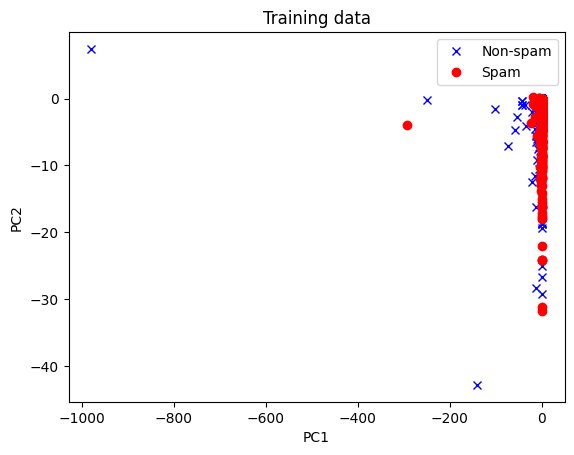

In [ ]:
# Plotting the new 2D data while differentiating between spam and ham data

# Getting the indices at which the training samples are ham (non-spam):
idx_ham = np.where(train_labels == 0)
# Getting the indices at which the training samples are spam:
idx_spam = np.where(train_labels == 1)

print("The percentage of data information retained is:", info_2d)

# Plotting
plt.figure()
plt.plot(new_x[idx_ham[0],0], new_x[idx_ham[0],1], 'xb', label = 'Non-spam')
plt.plot(new_x[idx_spam[0],0], new_x[idx_spam[0],1], 'ro', label = 'Spam')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Training data")

Text(0.5, 1.0, 'Training data - Closer look')

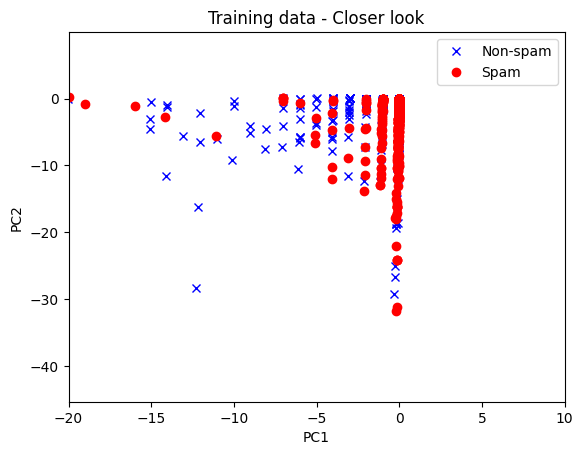

In [ ]:
# Taking a closer look at the data distribution

# Plotting
plt.figure()
plt.xlim([-20,10])
plt.plot(new_x[idx_ham[0],0], new_x[idx_ham[0],1], 'xb', label = 'Non-spam')
plt.plot(new_x[idx_spam[0],0], new_x[idx_spam[0],1], 'ro', label = 'Spam')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title("Training data - Closer look")

# **Testing K-means on the projected data (2D - Space) for k = 5**

In [ ]:
# Number of clusters
k = 2

# After observing that most of our data samples are around the point (0,0), we
# randomly choose our initial centers around that point for better performance
# of the algorihtm
initial_centers_ham = np.array([[0,0],[0,-20],[-1,-5],[-5,-10],[-10,-10]])
initial_centers_spam = np.array([[0,0],[0,-20],[-1,-5],[-5,-10],[-10,-10]])

# Applying K-means on the ham (non-spam) data
centers_ham , assignments_ham = my_kmeans(new_x[idx_ham[0]], k = k, initial_centers = initial_centers_ham)

# Applying K-means on the spam data
centers_spam , assignments_spam = my_kmeans(new_x[idx_spam[0]], k = k, initial_centers = initial_centers_spam)

Text(0.5, 1.0, 'Clustering Spam and Ham Data with k = 2')

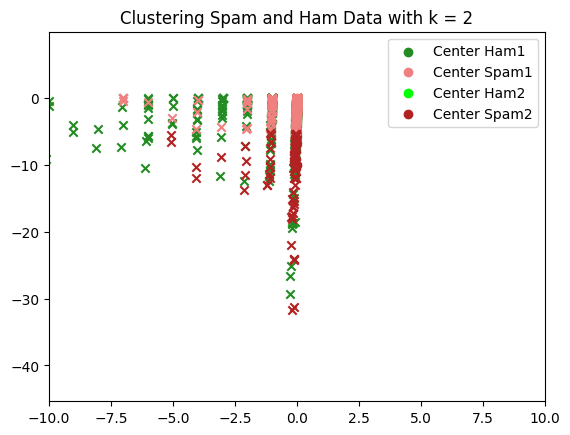

In [ ]:
# Plotting
plt.figure()
colors_ham = ['forestgreen','lime','aquamarine','powderblue','aqua']
colors_spam = ['lightcoral','firebrick','tomato','chocolate','peachpuff']

ham_2d = new_x[idx_ham[0]]
spam_2d = new_x[idx_spam[0]]

for i in range(k):
  # Grouping the points that belong to one cluster for each class
  cluster_ham = np.where(assignments_ham[:,i] == 1)
  cluster_spam = np.where(assignments_spam[:,i] == 1)

  # Plotting Ham center
  plt.scatter(centers_ham[i,0],centers_ham[i,1], c = colors_ham[i], marker = 'o', label = "Center Ham" + str(i+1))
  # Plotting Ham data points
  plt.scatter(ham_2d[cluster_ham[0],0], ham_2d[cluster_ham[0],1], c = colors_ham[i], marker = 'x')

  # Plotting Spam center
  plt.scatter(centers_spam[i,0],centers_spam[i,1], c = colors_spam[i], marker = 'o', label = "Center Spam" + str(i+1))
  # Plotting Spam data points
  plt.scatter(spam_2d[cluster_spam[0],0], spam_2d[cluster_spam[0],1], c = colors_spam[i], marker = 'x')

plt.xlim([-10,10])

plt.legend()
plt.title("Clustering Spam and Ham Data with k = 2")

# **Finding the best K using cross-validation (2D data)**

K =  1 , Cross-validation iteration: 0 Training Accuracy: 0.7165133946421431, Validation Accuracy: 0.6789137380191693
K =  1 , Cross-validation iteration: 1 Training Accuracy: 0.7057177129148341, Validation Accuracy: 0.7220447284345048
K =  1 , Cross-validation iteration: 2 Training Accuracy: 0.7082334132693845, Validation Accuracy: 0.712
K =  1 , Cross-validation iteration: 3 Training Accuracy: 0.7090327737809752, Validation Accuracy: 0.7088
K =  1 , Cross-validation iteration: 4 Training Accuracy: 0.7054356514788169, Validation Accuracy: 0.7232
K =  2 , Cross-validation iteration: 0 Training Accuracy: 0.6069572171131548, Validation Accuracy: 0.6038338658146964
K =  2 , Cross-validation iteration: 1 Training Accuracy: 0.6065573770491803, Validation Accuracy: 0.6214057507987221
K =  2 , Cross-validation iteration: 2 Training Accuracy: 0.3745003996802558, Validation Accuracy: 0.3856
K =  2 , Cross-validation iteration: 3 Training Accuracy: 0.7122302158273381, Validation Accuracy: 0.7264

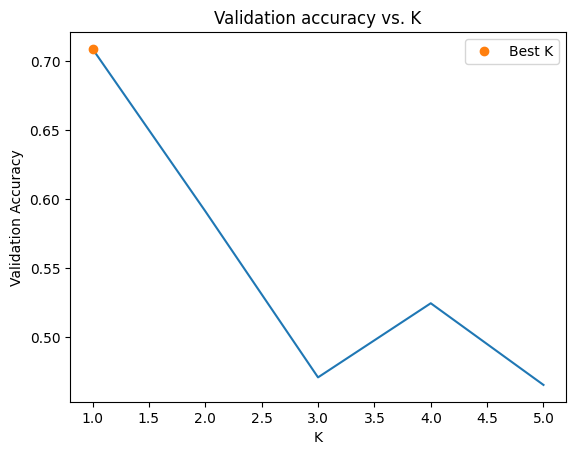

In [ ]:
# Defining the number of splits for cross-validation
g = 5   # Create 5 folds to be able to use 80% of the data for training later and 20% for validation

# Maximum number of clusters to consider for K-means
K = 6

# Finding the best K
chosen_k = k_estimator(new_x,train_labels, g, K)

As shown in the plot, the best K is 1, with a validation accuracy of 70.9%.

# **Reducing the dimensionality of our data while keeping 95% of the data information**


In [ ]:
# Applying PCA on the training data with p = 0.95
x_95, U_95 , info_95, count_95 = my_PCA(train_data, None, 0.95)

print("The number of principal components is:", count_95)
print("The percentage of data information kept is:", info_95)

The number of principal components is: 3
The percentage of data information kept is: 0.9520381358169219


Text(0.5, 0.92, 'Training data')

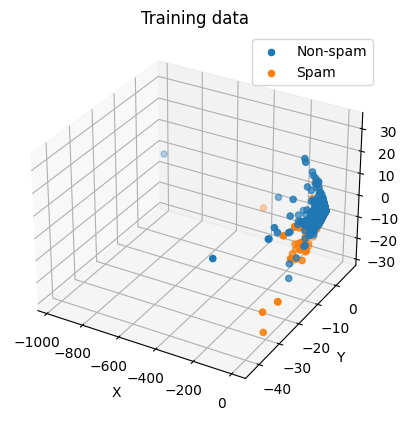

In [ ]:
# Taking a look at our 3D data
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection ="3d")
ax.scatter3D(x_95[idx_ham[0],0], x_95[idx_ham[0],1], x_95[idx_ham[0],2], 'b', label = 'Non-spam')
ax.scatter3D(x_95[idx_spam[0],0], x_95[idx_spam[0],1], x_95[idx_spam[0],2], 'r', label = 'Spam')
plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Training data")

# **Testing K-means on the projected data (3D - Space) with k = 2**

In [ ]:
# Number of clusters
k = 2

# After observing that most of our data samples are around the point (0,0), we
# randomly choose our initial centers around that point for better performance
# of the algorihtm
initial_centers_ham_95 = np.array([[0,0,0],[0,-20,20]])
initial_centers_spam_95 = np.array([[0,0,0],[0,-20,-20]])

# Applying K-means on the ham (non-spam) data
centers_ham_95 , assignments_ham_95 = my_kmeans(x_95[idx_ham[0]], k = k, initial_centers = initial_centers_ham_95)

# Applying K-means on the spam data
centers_spam_95 , assignments_spam_95 = my_kmeans(x_95[idx_spam[0]], k = k, initial_centers = initial_centers_spam_95)

Text(0.5, 0.92, 'Clustering Spam and Ham Data with k = 2')

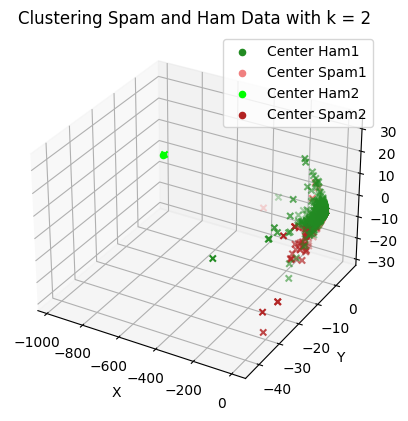

In [ ]:
# Plotting
k=2
fig = plt.figure()
ax = plt.axes(projection ="3d")
colors_ham = ['forestgreen','lime','aquamarine','powderblue','aqua']
colors_spam = ['lightcoral','firebrick','tomato','chocolate','peachpuff']

ham_95 = x_95[idx_ham[0]]
spam_95 = x_95[idx_spam[0]]

for i in range(k):
  # Grouping the points that belong to one cluster for each class
  cluster_ham_95 = np.where(assignments_ham_95[:,i] == 1)
  cluster_spam_95 = np.where(assignments_spam_95[:,i] == 1)

  # Plotting Ham center
  ax.scatter3D(centers_ham_95[i,0],centers_ham_95[i,1],centers_ham_95[i,2], c = colors_ham[i], marker = 'o', label = "Center Ham" + str(i+1))
  # Plotting Ham data points
  ax.scatter3D(ham_95[cluster_ham_95[0],0], ham_95[cluster_ham_95[0],1],ham_95[cluster_ham_95[0],2], c = colors_ham[i], marker = 'x')

  # Plotting Spam center
  ax.scatter3D(centers_spam_95[i,0],centers_spam_95[i,1],centers_spam_95[i,2], c = colors_spam[i], marker = 'o', label = "Center Spam" + str(i+1))
  # Plotting Spam data points
  ax.scatter3D(spam_95[cluster_spam_95[0],0], spam_95[cluster_spam_95[0],1], spam_95[cluster_spam_95[0],2], c = colors_spam[i], marker = 'x')

plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Clustering Spam and Ham Data with k = 2")

# **Finding the best K using cross-validation (3D data)**

K =  1 , Cross-validation iteration: 0 Training Accuracy: 0.7165133946421431, Validation Accuracy: 0.6789137380191693
K =  1 , Cross-validation iteration: 1 Training Accuracy: 0.7057177129148341, Validation Accuracy: 0.7220447284345048
K =  1 , Cross-validation iteration: 2 Training Accuracy: 0.7082334132693845, Validation Accuracy: 0.712
K =  1 , Cross-validation iteration: 3 Training Accuracy: 0.7090327737809752, Validation Accuracy: 0.7088
K =  1 , Cross-validation iteration: 4 Training Accuracy: 0.7054356514788169, Validation Accuracy: 0.7232
K =  2 , Cross-validation iteration: 0 Training Accuracy: 0.7165133946421431, Validation Accuracy: 0.6789137380191693
K =  2 , Cross-validation iteration: 1 Training Accuracy: 0.7333066773290684, Validation Accuracy: 0.7571884984025559
K =  2 , Cross-validation iteration: 2 Training Accuracy: 0.7178257394084733, Validation Accuracy: 0.7216
K =  2 , Cross-validation iteration: 3 Training Accuracy: 0.7094324540367706, Validation Accuracy: 0.7056

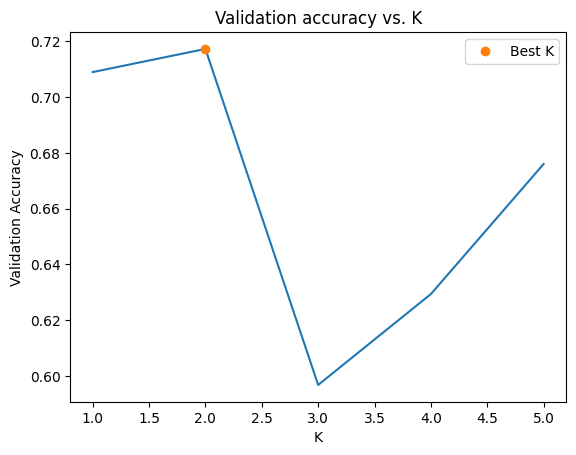

In [ ]:
# Defining the number of splits for cross-validation
g = 5   # Create 5 folds to be able to use 80% of the data for training later and 20% for validation

# Maximum number of clusters to consider for K-means
K = 6

# Finding the best K
chosen_k_95 = k_estimator(x_95, train_labels, g, K)

As shown by the plot, the best K is 2 with a validation accuracy of 71.3%.

# **Predicting the Labels of the Test Data**

In order to predict the labels of the test data, we apply PCA to the test set the same way it was applied to the train set. We then apply K-means to the training data to obtain the cluster centers. We finally use our classifier function to assign each sample to a Spam or Ham cluster.

Since the best validation accuracy was achieved with 3 and 2 clusters per class, we choose to reduce the dimensionality of the test data to 3 and apply K-means with k = 2.

In [ ]:
# Apply PCA to the test data to reduce its dimensionality to 3 principal components
test_3d, U_test , info_3d_test, count_3d = my_PCA(test_data, 3, None)

# Divide into Ham and Spam training data
ham_95 = x_95[idx_ham[0]]
spam_95 = x_95[idx_spam[0]]

# Initialize Centers for K-means
k_best_final = 2
initial_ham_centers_95 = select_k_random_points(ham_95, k_best_final)
initial_spam_centers_95 = select_k_random_points(spam_95, k_best_final)

# Apply K-means to the training data to obtain the training data. Choose the best number of clusters k obtained from cross-validation
final_center_ham_95, final_assignments_ham_95 = my_kmeans(x_95[idx_ham[0]], k_best_final, initial_ham_centers_95)
final_centers_spam_95, final_assignments_spam_95 = my_kmeans(x_95[idx_spam[0]], k_best_final, initial_spam_centers_95)

# Predict labels of test data
predicted_test_labels, assignments_test = my_classifier(test_3d, final_center_ham_95, final_centers_spam_95)

# Store predicted test labels in npz file
dir = '/content/gdrive/MyDrive/SML_Project/'
filename = 'predicted_test_labels.npz'
np.savez_compressed(dir + filename, arr = predicted_test_labels)

# **Plotting the Classified Test Data**

Text(0.5, 0.92, 'Clustering of Test Data')

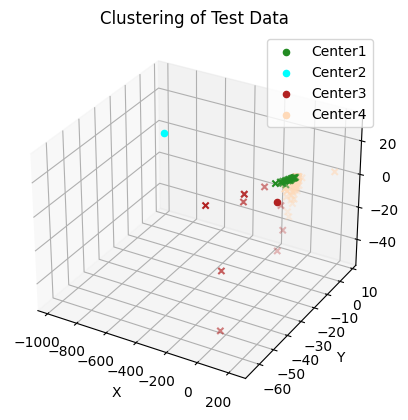

In [ ]:
# Plotting the clustered data:
fig = plt.figure()
ax = plt.axes(projection ="3d")
colors = ['forestgreen','aqua','firebrick','peachpuff']

# Combination of 2 ham centers, 2 spam centers
k_ham_spam = 4
final_centers = np.vstack((final_center_ham_95, final_centers_spam_95))

for i in range(k_ham_spam):
  # Plotting centers
  ax.scatter3D(final_centers[i,0],final_centers[i,1],final_centers[i,2], c = colors[i], marker = 'o', label = "Center" + str(i+1))
  # Getting all points that belong to cluster i
  cluster_test = np.where(assignments_test[:,i] == 1)
  # Plotting data points
  ax.scatter3D(test_3d[cluster_test[0],0], test_3d[cluster_test[0],1], test_3d[cluster_test[0],2], c = colors[i], marker = 'x')

plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Clustering of Test Data")


Clusters 1 and 2 are Ham while clusters 3 and 4 are spam.

Text(0.5, 0.92, 'Classification of Test Data')

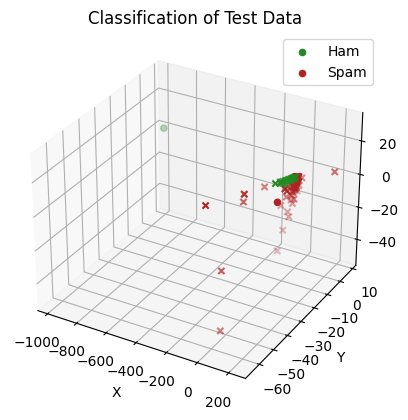

In [ ]:
# Plotting the classified data
fig = plt.figure()
ax = plt.axes(projection ="3d")

for i in range(k_ham_spam):
  # Getting all points that belong to cluster i
  cluster_test = np.where(assignments_test[:,i] == 1)
  if i < k_ham_spam/2:
    # Plotting data points
    ax.scatter3D(test_3d[cluster_test[0],0], test_3d[cluster_test[0],1], test_3d[cluster_test[0],2], c = 'forestgreen', marker = 'x')
  else:
    ax.scatter3D(test_3d[cluster_test[0],0], test_3d[cluster_test[0],1], test_3d[cluster_test[0],2], c = 'firebrick', marker = 'x')

# Plotting the centers
ax.scatter3D(final_center_ham_95[:,0],final_center_ham_95[:,1],final_center_ham_95[0,2], c = 'forestgreen', marker = 'o', label = 'Ham')
ax.scatter3D(final_centers_spam_95[:,0],final_centers_spam_95[:,1],final_centers_spam_95[0,2], c = 'firebrick', marker = 'o', label = 'Spam')

plt.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Classification of Test Data")





---



---



---



# **Comments**

- Projecting on 2 dimensions is useful to visualise the 32 dimensional data using a 2D plot. However, we notice that the data points of the two classes ham and spam heavily overlap in the 2d space. Seperating them is therefore more difficult.
- In the 3D space, the data is better distributed in the vertical direction (Z-axis) and therefore it is easier to seperate the 2 classes and classify the data samples.


---

**In the 2D case:**

As seen by the cross-validation process, increasing the number of clusters reduces the validation accuracies. The best accuracy was achieved for 1 cluster per class as there is no clear differentiation between the classes'clusters.



---

**In the 3D case:**

Using 2 clusters per class, we were able to achieve the best validation accuracy (71.3%). A clear differenciation can be made between the classes whereby the spam data is concentrated on the lower Z-axis while the non-spam(ham) data is concentrated on the higher end of the Z-axis. Another cluster for each class is used to account for the outliers of each class.



---
**Conclusion:**

The best validation accuracy result 71.3% was obtained with the 3D data and with 2 clusters per class. Therefore to classify test (or unseen) data, we project the test data onto the 3D space using PCA and classify it by proximity to 2 centers per class found using k-means applied on the training data.


